# Stock Retirement GUI

In [6]:
import yfinance as yf
import pandas as pd
import tkinter as tk
from tkinter import ttk
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.figure import Figure 
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

In [7]:
pd.set_option('display.float_format', '{:.2f}'.format)

In [8]:
# Ticker Frame Command

budgetList = []
stockList = []

def create_input_fields():
    # Clear any existing inputs
    for widget in tickerFrame.winfo_children():
        widget.destroy()
    
    # Clearing the stocks and budget list 
    budgetList.clear()
    stockList.clear()

    # Get the number of input fields from the Spinbox to create 
    num_fields = int(spinBox.get())
    
    # Create input fields based on the number chosen
    for i in range(num_fields):
        stock_label = tk.Label(master=tickerFrame, text=f'Stock {i + 1}:', font='Arial 14')
        stock_entry = tk.Entry(master=tickerFrame, font='Arial 14')
        stock_label.grid(row=i, column=0, padx=5, pady=5)
        stock_entry.grid(row=i, column=1, padx=5, pady=5)
        
        budget_label = tk.Label(master=tickerFrame, text=f'Monthly Contributions:', font='Arial 14')
        budget_entry = tk.Entry(master=tickerFrame, font='Arial 14')
        budget_label.grid(row=i, column=3, padx=5, pady=5)
        budget_entry.grid(row=i, column=4, padx=5, pady=5)
    
    # Turning entrys from budget_label to integers
    stockList.append(stock_entry)
    budgetList.append(budget_entry)
    
    calcButton = tk.Button(master=tickerFrame, text='CALCULATE', font='Arial 24 bold', command= calculate)
    calcButton.grid(row= num_fields, column= 0, columnspan= 5, pady= 20)  # Place the button below the input fields

In [9]:
# Calculate command

def calculate():
    try:
        budget_values = [int(entry.get()) for entry in budgetList]
        stock_symbols = [entry.get().upper() for entry in stockList]
        
    except ValueError:
        messagebox.showerror("Error")
    
    # Clearing the graph after every calculation
    for widget in graphFrame.winfo_children():
        widget.destroy()

    stockDict = {stock_symbols[i]: budget_values[i] for i in range(len(stock_symbols))}

    totalDF = []

    for stock in stock_symbols:
        data = yf.Ticker(stock)
        df = data.history(period='max')
        df = df[['Close']]
        df['stock'] = stock
        df.reset_index(inplace=True)
        df['day'] = df['Date'].dt.date
        df['year'] = df['Date'].dt.year
        dateDF = df.groupby(['stock', 'year'])['day'].agg(min_day=('min'), max_day=('max')).reset_index()

        minDF = dateDF.merge(df, left_on=['stock', 'min_day'], right_on=['stock', 'day'])
        maxDF = dateDF.merge(df, left_on=['stock', 'max_day'], right_on=['stock', 'day'])

        minDF.rename(columns={'Close': 'min_close'}, inplace=True)
        maxDF.rename(columns={'Close': 'max_close'}, inplace=True)

        minDF = minDF[['stock', 'year_x', 'min_close']]
        maxDF = maxDF[['stock', 'year_x', 'max_close']]

        df = minDF.merge(maxDF, left_on=['stock', 'year_x'], right_on=['stock', 'year_x'])
        df['yoy'] = ((df['max_close'] - df['min_close']) / df['min_close']) * 100

        avgYoY = df.groupby('stock')['yoy'].mean()
        avgYoY = avgYoY.reset_index()
        avgYoY = avgYoY.rename(columns={'yoy': 'avg'})

        totalDF.append(avgYoY)

    avgDF = pd.concat(totalDF, ignore_index=True)
    avgDict = dict(zip(avgDF['stock'], avgDF['avg']))


    annualResults = {}

    # Calculate future value based on monthly contributions and annual returns
    
    years = int(yearsspinBox.get())
    
    for stock in avgDict:
        stockResults = []
        monthlyContributions = stockDict[stock]
    
        # Calculate monthly return rate
        monthly_return = (1 + avgDict[stock] / 100) ** (1/12) - 1

        for year in range(1, years + 1):
            n = year * 12  
            future_value = monthlyContributions * ((1 + monthly_return) ** n - 1) / monthly_return * (1 + monthly_return)

            stockResults.append(future_value)

        annualResults[stock] = stockResults


    annualDF = pd.DataFrame(annualResults)
    annualDF = annualDF.round(decimals= 2)
    annualDF.reset_index(inplace= True)
    annualDF.rename(columns= {'index': 'year'}, inplace= True)
    annualDF['year'] = annualDF['year'] + 1
    annualDF['total'] = annualDF.iloc[:, 1:].sum(axis= 1)
    annualDF['total'] = annualDF['total'].round(decimals= 2)


    # Creating unique title for Label
    finalTotal = annualDF['total'].iloc[-1]
    finalTotalRound = round(finalTotal, 0)
    totalString = str(finalTotalRound)
    totalString = totalString.split('.')[0]

    if len(totalString) > 15:
        numLength = 'Quadrillion'
    elif len(totalString) > 12:
        numLength = 'Trillion'
    elif len(totalString) > 9:
        numLength = 'Billions'
    elif len(totalString) > 6:
        numLength = 'Millions'
    elif len(totalString) > 3:
        numLength = 'Thousands'
    else:
        numLength = 'Dollars'


    # Value per year Graph
    fig, ax = plt.subplots(figsize=(9, 4))
    
    ax.bar(annualDF['year'], annualDF['total'], label='Total', color='orange')

    ax.set_xlabel('Year')
    ax.set_ylabel(f'Amount in {numLength}')
    ax.set_title(f'Value Over {years} Years')
    ax.set_xticks(annualDF['year'])
    ax.set_xticklabels(annualDF['year'], rotation=45)

    fig.tight_layout()
    
    # Adding the matplotlib image to the gui
    canvas = FigureCanvasTkAgg(fig, master= graphFrame)
    canvas.draw()
    canvas.get_tk_widget().pack()
    
    
    # Tax graph and calculations
    
    # Federal Tax
    if finalTotal > 518901:
        fedBracket1 = (finalTotal - 518901) * .2
        fedBracket2 = (518900 - 47026) * .15
        fedTax = fedBracket1 + fedBracket2
    elif 47026 <= finalTotal <= 518900:
        fedTax = (finalTotal - 47026) * .15
    else:
        fedTax = finalTotal * 0

    # California State Tax
    if finalTotal < 8932:
        stateTax = finalTotal * .01
    elif 8933 <= finalTotal <= 21175:
        stateTax1 = 8932 * .01
        stateTax2 = (21175 - 8933) * .02
        stateTax = stateTax1 + stateTax2
    elif 21176 <= finalTotal <= 33421:
        stateTax1 = 8932 * .01
        stateTax2 = (21175 - 8933) * .02
        stateTax3 = (33421 - 21176) * .04
        stateTax = stateTax1 + stateTax2 + stateTax3
    elif 33422 <= finalTotal <= 46394:
        stateTax1 = 8932 * .01
        stateTax2 = (21175 - 8933) * .02
        stateTax3 = (33421 - 21176) * .04
        stateTax4 = (46394 - 33422) * .06
        stateTax = stateTax1 + stateTax2 + stateTax3 + stateTax4
    elif 46395 <= finalTotal <= 58634:
        stateTax1 = 8932 * .01
        stateTax2 = (21175 - 8933) * .02
        stateTax3 = (33421 - 21176) * .04
        stateTax4 = (46394 - 33422) * .06
        stateTax5 = (58634 - 46395) * .08
        stateTax = stateTax1 + stateTax2 + stateTax3 + stateTax4 + stateTax5
    elif 58635  <= finalTotal <= 299508:
        stateTax1 = 8932 * .01
        stateTax2 = (21175 - 8933) * .02
        stateTax3 = (33421 - 21176) * .04
        stateTax4 = (46394 - 33422) * .06
        stateTax5 = (58634 - 46395) * .08
        stateTax6 = (299508 - 58635) * .093
        stateTax = stateTax1 + stateTax2 + stateTax3 + stateTax4 + stateTax5 + stateTax6
    elif 299509  <= finalTotal <= 599012:
        stateTax1 = 8932 * .01
        stateTax2 = (21175 - 8933) * .02
        stateTax3 = (33421 - 21176) * .04
        stateTax4 = (46394 - 33422) * .06
        stateTax5 = (58634 - 46395) * .08
        stateTax6 = (299508 - 58635) * .093
        stateTax7 = (599012 - 299509) * .103
        stateTax = stateTax1 + stateTax2 + stateTax3 + stateTax4 + stateTax5 + stateTax6 + stateTax7
    elif finalTotal >= 599013:
        stateTax1 = 8932 * .01
        stateTax2 = (21175 - 8933) * .02
        stateTax3 = (33421 - 21176) * .04
        stateTax4 = (46394 - 33422) * .06
        stateTax5 = (58634 - 46395) * .08
        stateTax6 = (299508 - 58635) * .093
        stateTax7 = (599012 - 299509) * .103
        stateTax8 = (finalTotal - 599013) * .123
        stateTax = stateTax1 + stateTax2 + stateTax3 + stateTax4 + stateTax5 + stateTax6 + stateTax7 + stateTax8

    totalTax = stateTax + fedTax
    net = finalTotal - totalTax



    # Plotting the tax graph
    fig, ax = plt.subplots(figsize=(9, 4))

    # Bar heights
    gross_amount = finalTotal
    total_tax = totalTax
    net_amount = net
    taxPercentage = round((totalTax / finalTotal) * 100, 2)

    # Bar positions
    bar_width = 0.35
    x = np.arange(len(['Gross Amount', 'Total Tax', 'Net Amount']))  

    # Plot bars
    ax.bar(x[0], gross_amount, width=bar_width, color='blue', label='Gross Amount')
    ax.bar(x[1], total_tax, width=bar_width, color='red', label='Total Tax')
    ax.bar(x[2], net_amount, width=bar_width, color='purple', label='Net Amount')

    ax.text(x[0], gross_amount + 0.5, f'${gross_amount:,.2f}', ha='center', va='bottom', fontsize=11, color='black')
    ax.text(x[1], total_tax + 0.5, f'${total_tax:,.2f}', ha='center', va='bottom', fontsize=11, color='black')
    ax.text(x[2], net_amount + 0.5, f'${net_amount:,.2f}', ha='center', va='bottom', fontsize=11, color='black')

    ax.set_title(f'Tax is {taxPercentage}%', fontsize=14, y=0.9)
    ax.set_xticks(x)
    ax.set_xticklabels(['Gross Amount', 'Total Tax', 'Net Amount'])

    fig.tight_layout()
    
    canvas = FigureCanvasTkAgg(fig, master= graphFrame)
    canvas.draw()
    canvas.get_tk_widget().pack()


    # Clearing lists
    clear_inputs()

# Clearing the input fields
def clear_inputs():
    for entry in stockList:
        entry.delete(0, 'end')
    for entry in budgetList:
        entry.delete(0, 'end')

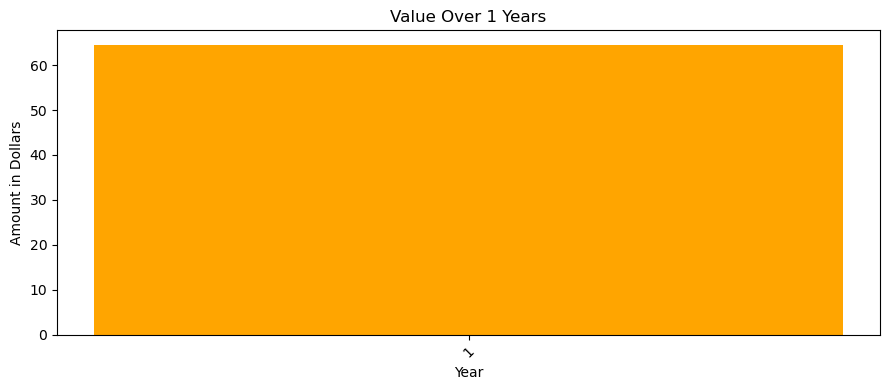

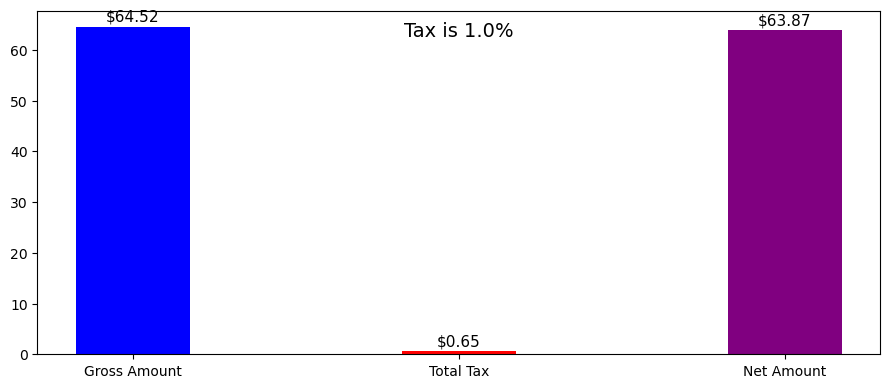

In [10]:
# Window
root = tk.Tk()
root.title('Stock Retirement GUI')

# Root size
root.geometry('1500x1400')

# Title
titleLabel = tk.Label(master= root, text= 'Retirement Calculator', font= 'Arial 24 bold')
titleLabel.pack(padx= 20, pady= 20)

# Stock numbers input field
inputFrame = tk.Frame(master= root)
inputLabel = tk.Label(master= inputFrame, text= 'Number of Stocks', font= 'Arial 20')
spinBox = tk.Spinbox(master= inputFrame, from_= 1, to= 5) # Spinbox widget
button = tk.Button(master= inputFrame, text= 'Enter', command= create_input_fields)
inputLabel.pack(padx= 35, pady= 5)
spinBox.pack(side= 'left')
button.pack(side= 'left')
inputFrame.pack(padx= 20, pady= 20)

# Year number input field
yearsFrame = tk.Frame(master= root)
yearsLabel = tk.Label(master= yearsFrame, text= 'Number of Years', font= 'Arial 20')
yearsspinBox = tk.Spinbox(master= yearsFrame, from_= 1, to= 60) 
yearsLabel.pack(padx= 35, pady= 5)
yearsspinBox.pack(side= 'left')
yearsFrame.pack(padx= 20, pady= 20)

# Ticker frame
tickerFrame = tk.Frame(master=root)
tickerFrame.pack(padx=20, pady=20)

# Graph frame
graphFrame = tk.Frame(master=root)
graphFrame.pack(padx=20, pady=20)


root.mainloop()